In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [2]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [4]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]

In [5]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1183 non-null   object 
 1   Close   1183 non-null   float64
 2   Volume  1183 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.9+ KB


**Data Time Period**

In [6]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2023-12-29')

## Visualize the data

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

## Data Preprocessing

In [9]:
df[['Close','Volume']].head()

,Close,Volume
0,62.442001,16146000
1,63.227501,26398000
2,62.799999,20376000
3,63.172501,22146000
4,63.609001,24828000


In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Close','Volume']])
scaled_train = scaler.transform(df[['Close','Volume']])
#train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])

In [11]:
scaled_train[0:5]

array([[-1.3374812 , -1.00458351],
       [-1.31047676, -0.21576535],
       [-1.32517371, -0.67911523],
       [-1.31236759, -0.54292638],
       [-1.2973613 , -0.33656564]])

In [12]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    Xs.append(data[i:i+window_size,:])
    Ys.append(data[i+window_size,:])
  return np.array(Xs), np.array(Ys)

In [13]:
TIME_STEPS = 5
X_train, Y_train= generate_sequences(scaled_train, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training input shape: ", Y_train.shape)

Training input shape:  (1178, 5, 2)
Training input shape:  (1178, 2)


In [14]:
X_train[0]

array([[-1.3374812 , -1.00458351],
       [-1.31047676, -0.21576535],
       [-1.32517371, -0.67911523],
       [-1.31236759, -0.54292638],
       [-1.2973613 , -0.33656564]])

In [15]:
Y_train[0]

array([-1.27088983,  1.59931661])

In [16]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

In [17]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(X_train.shape[2]))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 116,610
Trainable params: 116,610
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [18]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                    shuffle=False)

Epoch 1/100
30/30 [==============================] - 8s 58ms/step - loss: 1.0130 - val_loss: 0.7213
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 0.6736 - val_loss: 0.4744
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.5816 - val_loss: 0.4058
Epoch 4/100
30/30 [==============================] - 0s 17ms/step - loss: 0.4606 - val_loss: 0.4756
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 0.5392 - val_loss: 0.3649
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4150 - val_loss: 0.3249
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4345 - val_loss: 0.3063
Epoch 8/100
30/30 [==============================] - 0s 15ms/step - loss: 0.3969 - val_loss: 0.3376
Epoch 9/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4017 - val_loss: 0.2903
Epoch 10/100
30/30 [==============================] - 1s 18ms/step - loss: 0.3942 - val_loss: 0.3945

#### Plot Training - Validation loss

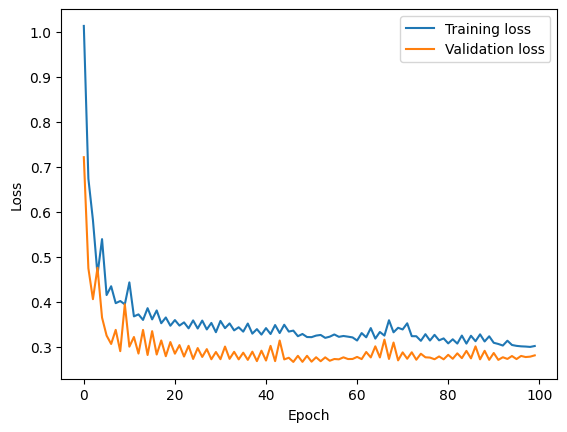

In [19]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [20]:
model.save('saved_models/lstm_multi.h5')

## Predict Anomalies on test data using threshold

In [21]:
new_df = pd.read_csv('Stocks\Test.csv')
new_df = new_df[['Date','Close','Volume']]
scaled_new_test = scaler.transform(new_df[['Close','Volume']])

X_new, Y_new = generate_sequences(scaled_new_test, TIME_STEPS)
new_test_pred = model.predict(X_new, verbose=1)


3/3 [==============================] - 1s 8ms/step


In [22]:
new_test_pred

array([[ 1.1680486 , -0.7551472 ],
       [ 1.1918862 , -0.7335974 ],
       [ 1.2305608 , -0.7801032 ],
       [ 1.2611849 , -0.77645695],
       [ 1.2948632 , -0.82622063],
       [ 1.30457   , -0.76901186],
       [ 1.2988825 , -0.77147615],
       [ 1.3095961 , -0.73800063],
       [ 1.2946706 , -0.45509246],
       [ 1.3340082 , -0.5115368 ],
       [ 1.3780577 , -0.7052983 ],
       [ 1.409518  , -0.7095107 ],
       [ 1.4595408 , -0.65990055],
       [ 1.4985926 , -0.6667203 ],
       [ 1.51777   , -0.62587535],
       [ 1.4813535 , -0.42221913],
       [ 1.3298903 ,  0.14817488],
       [ 1.3214461 , -0.44047853],
       [ 1.2372653 , -0.09317401],
       [ 1.2566359 , -0.33130807],
       [ 1.3069286 , -0.5640522 ],
       [ 1.3427923 , -0.59222305],
       [ 1.3923821 , -0.6868949 ],
       [ 1.3877255 , -0.577909  ],
       [ 1.4011335 , -0.6553602 ],
       [ 1.3987304 , -0.67700255],
       [ 1.4010563 , -0.7302456 ],
       [ 1.3282037 , -0.45862374],
       [ 1.3032081 ,

In [23]:
pred_dict = {
    'Predicted_Close': new_test_pred[:, 0],
    'Predicted_Volume': new_test_pred[:, 1],
    'Actual_Close': Y_new[:, 0],
    'Actual_Volume': Y_new[:, 1],
}

In [24]:
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

,Predicted_Close,Predicted_Volume,Actual_Close,Actual_Volume
0,1.168049,-0.755147,1.416869,-0.740385
1,1.191886,-0.733597,1.459499,-0.966428
2,1.230561,-0.780103,1.455029,-0.902627
3,1.261185,-0.776457,1.474625,-1.170072
4,1.294863,-0.826221,1.469125,-0.769685


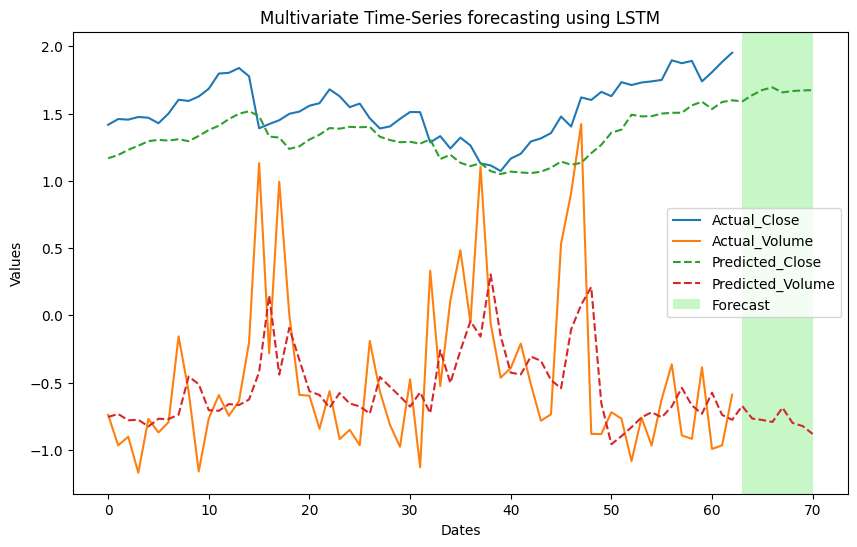

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(pred_df) * 0.9)  
highlight_end = len(pred_df) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(pred_df[['Actual_Close', 'Actual_Volume']][:highlight_start], label=['Actual_Close', 'Actual_Volume'])
 
# Plot predicted values with a dashed line
plt.plot(pred_df[['Predicted_Close', 'Predicted_Volume']], label=['Predicted_Close', 'Predicted_Volume'], linestyle='--')
 
# Highlight the forecasted portion with a different color
plt.axvspan(pred_df.index[highlight_start], pred_df.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
 
plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()